In [89]:
import torch
import sys
import matplotlib as mpl
from matplotlib import pyplot as plt
from torch import vmap
import seaborn as sns
import numpy as np
from math import pi
import time

sys.path.append('../')
import interflow as itf
import interflow.fabrics as fabrics
import interflow.gmm as gmm
import interflow.stochastic_interpolant as stochastic_interpolant
import torch.distributions as D

from typing import Callable, Tuple



%load_ext autoreload
%autoreload 2


if torch.cuda.is_available():
    device = 'cuda'
    print('Using GPU.')
else:
    device = 'cpu'
    print('Using the cpu. No GPU!')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU.


In [17]:
def grab(tensor):
    return tensor.data.numpy()

In [69]:
a = torch.tensor(5.)
mu0 = torch.tensor([0.,0.]).to(device)
mu1 = torch.tensor([a - (2),a]).to(device)
C0 = torch.tensor([[1.,0.],[0.,a ]]).to(device)#.unsqueeze(0)
C1 = torch.tensor([[a, 0.],[0 ,1.]]).to(device)#.unsqueeze(0)


rho0 = D.MultivariateNormal(mu0,C0)
rho1 = D.MultivariateNormal(mu1, C1)       


In [ ]:
### Combined density

In [70]:
rho0_samples = grab(rho0.sample((10000,)))
rho1_samples = grab(rho1.sample((10000,)))





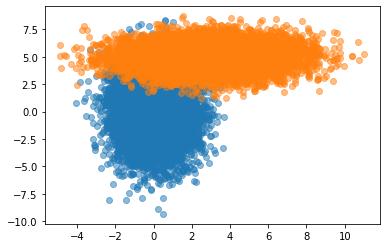

In [71]:
plt.scatter(rho0_samples[:,0], rho0_samples[:,1], alpha = 0.5)
plt.scatter(rho1_samples[:,0], rho1_samples[:,1], alpha = 0.5)

### Define score for mxiture

In [323]:
def make_score(mu0, mu1, C0, C1):
    
    def s(x):
        C0_inv = torch.linalg.inv(C0)
        C1_inv = torch.linalg.inv(C1)
        N0     = (2*pi)**(-1)* torch.linalg.det(C0)**(-1/2)*torch.exp(-(1/2)*(x-mu0) @ C0_inv @ (x-mu0))
        N1     = (2*pi)**(-1)* torch.linalg.det(C1)**(-1/2)*torch.exp(-(1/2)*(x-mu1) @ C1_inv @ (x-mu1))
        
        return (-C0_inv@(x-mu0)*N0 - C1_inv @(x-mu1)*N1)/(N0 + N1)

    return s

def make_log_prob(mu0, mu1, C0, C1):
    C0_inv = torch.linalg.inv(C0)
    C1_inv = torch.linalg.inv(C1)
    
    def log_prob(x):
        N0     = (2*pi)**(-1)* torch.linalg.det(C0)**(-1/2)*torch.exp(-(1/2)*(x-mu0) @ C0_inv @ (x-mu0))
        N1     = (2*pi)**(-1)* torch.linalg.det(C1)**(-1/2)*torch.exp(-(1/2)*(x-mu1) @ C1_inv @ (x-mu1))
        return torch.log( (1/2) * (N0 + N1))
    return log_prob

s = make_score(mu0, mu1, C0, C1)
s_batch = vmap(s)
xs = torch.randn(size=(10,2)).to(device)
s_batch(xs).shape


log_p = make_log_prob(mu0, mu1, C0, C1)
log_p_batch = vmap(log_p)
    

torch.Size([625, 2])


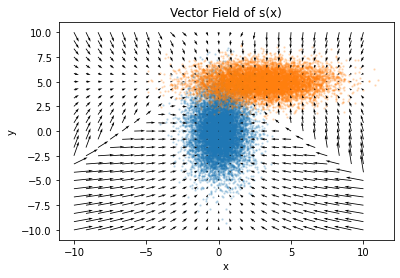

In [88]:
# Create a meshgrid
x = torch.linspace(-10, 10, 25)
y = torch.linspace(-10, 10, 25)
xx, yy = torch.meshgrid(x, y)
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
print(grid.shape)

# Evaluate the function on the grid
results = s_batch(grid)

# Reshape for plotting
u = results[:, 0].reshape(xx.shape)
v = results[:, 1].reshape(yy.shape)

# Plotting
plt.scatter(rho0_samples[:,0], rho0_samples[:,1], s = 2, alpha = 0.2)
plt.scatter(rho1_samples[:,0], rho1_samples[:,1], s = 2, alpha = 0.2)
plt.quiver(grab(xx), grab(yy), grab(u), grab(v), zorder=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of s(x)')
plt.show()

In [119]:
### unbatched

# import torch

# def interp_at_t(strings, ts, tprime):
#     # Ensure ts is sorted
#     # ts, sorted_indices = torch.sort(ts)
#     # strings = strings[sorted_indices]

#     # Searchsorted finds the indices where elements should be inserted to maintain order.
#     index = torch.searchsorted(ts, tprime, right=True)

#     # Handle edge cases
#     index = index.clamp(1, len(ts) - 1)

#     string1 = strings[index]
#     string0 = strings[index - 1]
#     ts1 = ts[index]
#     ts0 = ts[index - 1]

#     # Linear interpolation
#     return string0 + (tprime - ts0) / (ts1 - ts0) * (string1 - string0)

# # Example usage
# ts = torch.tensor([0, 0.5, 1.0])
# strings = torch.tensor([[0, 0], [0.5, torch.sqrt(torch.tensor(3/4))], [1, 0]])
# tprimes = torch.tensor([0.25, 0.75])

# # Assuming you have some vmap equivalent in PyTorch or using another framework
# # interpolated_values = [interp_at_t(strings, ts, tprime) for tprime in tprimes]

# # If you don't have vmap, you can use a simple list comprehension
# interpolated_values = torch.stack([interp_at_t(strings, ts, tprime) for tprime in tprimes])

# print(interpolated_values)


tensor([[0.2500, 0.4330],
        [0.7500, 0.4330]])


In [121]:
import torch

def batched_interp_at_t(strings, ts, tprimes):
    # Ensure ts is sorted
    ts, sorted_indices = torch.sort(ts)
    strings = strings[sorted_indices]

    # Searchsorted finds the indices where elements should be inserted to maintain order.
    indices = torch.searchsorted(ts, tprimes, right=True)

    # Handle edge cases
    indices = indices.clamp(1, len(ts) - 1)

    string1 = strings[indices]
    string0 = strings[indices - 1]
    ts1 = ts[indices]
    ts0 = ts[indices - 1]

    # Calculate the interpolation
    interp = string0 + (tprimes.unsqueeze(-1) - ts0.unsqueeze(-1)) / (ts1 - ts0).unsqueeze(-1) * (string1 - string0)

    return interp

# Testing the batched method
ts = torch.tensor([0, 0.5, 1.0])
strings = torch.tensor([[0, 0], [0.5, torch.sqrt(torch.tensor(3/4))], [1, 0]])
tprimes = torch.tensor([0.25, 0.75])

batched_results = batched_interp_at_t(strings, ts, tprimes)
print("Batched Results:\n", batched_results)


Batched Results:
 tensor([[0.2500, 0.4330],
        [0.7500, 0.4330]])


In [281]:
def interp_at_t(strings, ts, tprime):
    
    print((ts > tprime).shape)
    index = torch.argmax((ts > tprime).type(torch.float32))
    string1 = strings[index]
    string0 = strings[index - 1]
    ts1     = ts[index]
    ts0     = ts[index - 1]
    
    return string0 + (tprime - ts0)/(ts1 - ts0) * (string1 - string0)

def batched_interp_at_t(strings, ts, tprimes):
    # Ensure ts is sorted
    ts, sorted_indices = torch.sort(ts)
    strings = strings[sorted_indices]

    # Searchsorted finds the indices where elements should be inserted to maintain order.
    indices = torch.searchsorted(ts, tprimes, right=True)

    # Handle edge cases
    indices = indices.clamp(1, len(ts) - 1)

    string1 = strings[indices]
    string0 = strings[indices - 1]
    ts1 = ts[indices]
    ts0 = ts[indices - 1]

    # Calculate the interpolation
    interp = string0 + (tprimes.unsqueeze(-1) - ts0.unsqueeze(-1)) / (ts1 - ts0).unsqueeze(-1) * (string1 - string0)

    return interp

def step_string(
    string: torch.tensor,
    score: Callable,
    dt: float,
):
    n_disc = string.shape[0]
    
    # string: [n_disc, d] (per string)
    string[1:-1] = string[1:-1] + dt*score(string[1:-1])
    
    # compute_lengths
    dists = torch.sum((string[1:].reshape(n_disc-1, -1) - string[:-1].reshape(n_disc-1, -1))**2, axis=1)
    # print("DISTS:", dists.shape)
    sum_dists = torch.cumsum(dists, dim=0)
    sum_dists = sum_dists/ sum_dists[-1]
    
    sum_dists = torch.concatenate((torch.tensor((0.0,)).to(device), sum_dists), dim=0)
    # print(sum_dists)
    
    uniform_grid = torch.linspace(0.0, 1.0, n_disc).to(device)
    
    # print(len(sum_dists))
    return batched_interp_at_t(string, sum_dists, uniform_grid) # uniform_grid is new tprimes
    
    
    
    
    
    

In [293]:
# x0 = rho0.sample((1,))
# x1 = rho0.sample((1,))

x0 = torch.tensor([0, -4.0]).to(device)
x1 = torch.tensor([5., 5.0]).to(device)
print(x0, x1)

tensor([ 0., -4.], device='cuda:0') tensor([5., 5.], device='cuda:0')


(-7.0, 7.0)

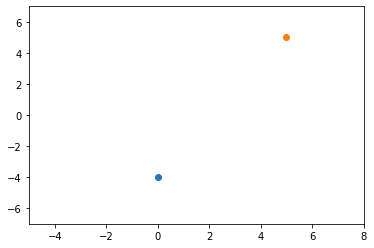

In [295]:
plt.scatter(grab(x0[0]), grab(x0[1]))
plt.scatter(grab(x1[0]), grab(x1[1]))
plt.xlim(-5,8)
plt.ylim(-7,7)

In [345]:
# string = torch.stack([x0*(1-t) + t*(x1) for t in ts]).to(device)

In [389]:
ts = torch.linspace(0,1,100).to(device)
string = torch.stack([x0*(1-t) + t*(x1) for t in ts]).to(device)
n_steps = 10
dt = .5

strings_over_time = []
new_string = string
strings_over_time.append(new_string)
for step in range(n_steps):
    new_string = step_string(new_string, s_batch, dt)
    strings_over_time.append(new_string)
    

In [386]:
final_string = grab(strings_over_time[-1])

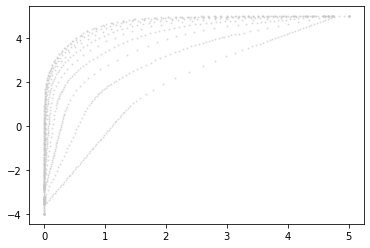

In [387]:
def create_color_sequence(start_color, end_color, n_steps):
    """Generate a sequence of colors from start_color to end_color."""
    return [start_color + (end_color - start_color) * i / (n_steps - 1) for i in range(n_steps)]

# Define the start (light gray) and end (green) colors in RGB
start_color = np.array([200, 200, 200]) / 255  # Light gray
end_color = np.array([0, 100, 20]) / 255       # Green

# Number of steps/colors you want in your sequence
steps = 1000

# Generate the color sequence
color_sequence = create_color_sequence(start_color, end_color, steps)


for i,string in enumerate(strings_over_time[:steps]):
    string = grab(string)
    # print(string)
    plt.scatter(string[:,0], string[:,1], color=color_sequence[i], alpha=0.5, s = 1)
    if i > steps:
        break

In [375]:
# final_string = grab(strings_over_time[80])
# # final_string

In [376]:
x = torch.linspace(-5, 10, 100)
y = torch.linspace(-8, 10, 100)
X, Y = torch.meshgrid(x, y)

# Step 3: Transform the grid points into vectors and evaluate the function
Z = torch.empty(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = log_p(torch.tensor([X[i, j], Y[i, j]]).to(device) )


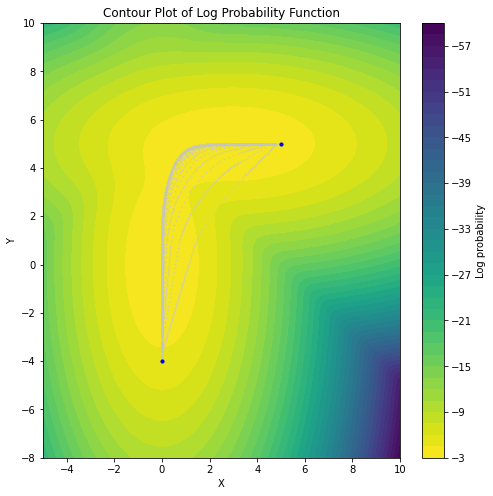

In [378]:
# Step 4: Plot the contour

fig = plt.figure(figsize=(8,8))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Log probability')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot of Log Probability Function')

for i,string in enumerate(strings_over_time[::1][:steps]):
    string = grab(string)
    # print(string)
    plt.scatter(string[:,0], string[:,1], color=color_sequence[::1][i], alpha=0.5, s = 1)
    if i > steps:
        break
        
        
plt.scatter(grab(x0[0]), grab(x0[1]), label = 'x0', s = 10, color = 'blue')
plt.scatter(grab(x1[0]), grab(x1[1]), label = 'x1', s = 10, color = 'blue')

plt.show()